# Modeling the Spread of Misinformation in Social Networks using Graph Theory.



## Introduction
In the age of digital communication, social media serves as the main platform for the exchange of information. However, as social media platforms have matured and become more popular, they have created new breeding grounds for the spread of harmful misinformation and disinformation campaigns. This notebook aims to model the spread of misinformation in social networks (e.g., Twitter, Facebook, Reddit, etc.) using graph theory. By representing social networks as graphs, it is possible to simulate and analyze how misinformation propagates through these networks, identify key nodes (influencers, bad actors, etc.), and identify possible strategies to mitigate the spread of misinformation and reduce the impact of disinformation campaigns.

### Initial Setup
Import the necessary libraries and set up the environment for graph modeling and analysis.

In [ ]:
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
from networkx import draw_networkx_edges
from matplotlib.colors import to_rgba


### Example Graph

In [17]:
G = nx.barabasi_albert_graph(200, 2)
nx.draw(G, node_size=50)

As you can see, the graph represents a fairly basic social network where every node (person) is connected with a few other nodes (friends). The Barabási-Albert model is used because it has *Preferential attachment* and seems to accurately represent the formation of *hubs* (influential persons/platforms) in real-world social networks. [REFERENCE NEEDED]

# Basic Simulation of Misinformation Spread (SI Model)

This simulation is using a **Competing SI (Competing Spread of Information) model** to observe the spread of two ideas ('*Truth*' and '*Misinformation*') across a Barabasi-Albert network of **100** nodes.
***
### The model is initialized with the following conditions:

$N$ = **100** (number of nodes) <br>
$M$ = **3** (minimum degree of each node)

**Network**: All nodes begin as 'Susceptible'

**Influencers**: a few high-degree (top 75th percentile) nodes are designated as '*Influencers*'

**Seeding**: a small and equal number of '*Good Actors*' (spreading truth) and '*Bad Actors*' (spreading misinformation) are randomly assigned among normal nodes. They act as the sources of truth and misinformation/disinformation, respectively.

In [16]:
%matplotlib notebook
# Define the types of information and virality of each information type
information_db = {
    'POLITICAL_MISINFO': {'type': 'misinformation', 'virality': 0.15},
    'SCIENTIFIC_MISINFO': {'type': 'misinformation', 'virality': 0.05},
    'POLITICAL_TRUTH': {'type': 'truth', 'virality': 0.10},
    'SCIENTIFIC_TRUTH': {'type': 'truth', 'virality': 0.04}
}

# Define node states
node_roles = {
    'NORMAL': {
        'convincing_power': 0.1,
        'shape': 'o',
        'base_size': 50,
    },
    'INFLUENCER': {
        'convincing_power': 0.5,
        'shape': 'o',
        'base_size': 75,
    },
    'GOOD_ACTOR': {
        'convincing_power': 0.025,
        'shape': '^',
        'base_size': 100,
    },
    'BAD_ACTOR': {
        'convincing_power': 0.025,
        'shape': 'v',
        'base_size': 100,
    }
}


# Define the colors for each node belief easier visualization.
color_map = {
    'SUSCEPTIBLE': 'gray',
    'SUSCEPTIBLE_INFLUENCER': 'yellow',
    'MISINFORMATION_INFLUENCER': 'lightred',
    'TRUTH_INFLUENCER': 'lightblue',
    'MISINFORMATION': 'red',
    'TRUTH': 'green',
}
N = 100 # number of nodes
M = 3 # minimum degree of each node
seed = random.randint(0, 100)

G = nx.barabasi_albert_graph(n=N, m=M, seed=seed)

def simulate_step(graph, roles_dict):
    # We collect nodes to update *after* looping
    # This prevents a node from being infected and spreading in the same step
    nodes_to_update = {} # Stores {node_to_infect: new_belief}
    counts = {'MISINFORMATION': 0, 'TRUTH': 0, 'SUSCEPTIBLE': 0}

    for node in graph.nodes():
        current_belief = graph.nodes[node]['belief']

        # 1. Check if this node is a spreader
        # NOTE: add immune condition later.
        if current_belief == 'MISINFORMATION' or current_belief == 'TRUTH':

            # 2. Get the spreader's convincing power from their role
            role = graph.nodes[node]['role']
            power = roles_dict[role]['convincing_power']

            # 3. Find susceptible neighbors
            for neighbor in graph.neighbors(node):
                if graph.nodes[neighbor]['belief'] == 'SUSCEPTIBLE':

                    # 4. Roll the dice
                    if random.random() < power:

                        # We only update if they haven't been marked by another belief
                        if neighbor not in nodes_to_update:
                            nodes_to_update[neighbor] = current_belief

    # 5. Apply all updates at once
    for node, new_belief in nodes_to_update.items():
        # Only update if they are still susceptible (first-come, first-served)
        if graph.nodes[node]['belief'] == 'SUSCEPTIBLE':
            graph.nodes[node]['belief'] = new_belief


    for node in G.nodes():
        counts[G.nodes[node]['belief']] += 1
    history.append(counts)

    return nodes_to_update

# Set all node roles to 'NORMAL' and to the 'SUSCEPTIBLE' belief state
for node in G.nodes():
    G.nodes[node]['role'] = 'NORMAL'
    G.nodes[node]['belief'] = 'SUSCEPTIBLE'

# Find and set influencer nodes based on their degree
all_degrees = [d for n, d in G.degree()]
all_degrees.sort(reverse=True)
highest_degree = all_degrees[0]

popularity_condition = lambda x: x > (highest_degree * 0.75)
for node in G.degree():
    if popularity_condition(node[1]):
        G.nodes[node[0]]['role'] = 'INFLUENCER'

# Randomly assign some GOOD_ACTOR and BAD_ACTOR nodes
GOOD_ACTORS_CAP = 2
BAD_ACTORS_CAP = 2
normal_nodes = [node for node in G.nodes() if G.nodes[node]['role'] == 'NORMAL']
random.shuffle(normal_nodes)

for i in range(GOOD_ACTORS_CAP):
    node_to_assign = normal_nodes.pop()
    G.nodes[node_to_assign]['role'] = 'GOOD_ACTOR'
    G.nodes[node_to_assign]['belief'] = 'TRUTH'

for i in range(BAD_ACTORS_CAP):
    node_to_assign = normal_nodes.pop()
    G.nodes[node_to_assign]['role'] = 'BAD_ACTOR'
    G.nodes[node_to_assign]['belief'] = 'MISINFORMATION'

# Set shapes based on node roles
node_shapes = []
for node in G.nodes():
    role = G.nodes[node]['role']
    node_shapes.append(node_roles[role]['shape'])

# Set sizes of nodes based on their roles
node_sizes = []
for node in G.nodes():
    role = G.nodes[node]['role']

    size = node_roles[role]['base_size']

    if role == 'INFLUENCER':
        size = size + (G.degree[node] * 10)

    node_sizes.append(size)

# Set colors based on node belief
node_colors = []
for node in G.nodes():
    belief = G.nodes[node]['belief']
    node_colors.append(color_map[belief])

pos = nx.spring_layout(G, seed=seed)

history = []
simulation_steps = 100

print("STARTING SIMULATION...")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,12))

title_obj = None
init_artists = None
# Goes from node role to a collection to node to index in that collection
node_map = {}

# Define lines for each belief state
line_sus, = ax2.plot([], [], label='Susceptible', color='gray', linestyle='--')
line_tru, = ax2.plot([], [], label='Truth', color='green', marker='.')
line_mis, = ax2.plot([], [], label='Misinformation', color='red', marker='.')

def create_node_map(role_name, collection, nodelist):
    """
    Map: node_map[role_name][collection] = { node: index_in_collection, ... }
    """
    node_to_idx = {node: i for i, node in enumerate(nodelist)}
    node_map.setdefault(role_name, {})[collection] = node_to_idx

def init():
    global title_obj, init_artists, line_mis, line_tru, line_sus

    draw_networkx_edges(G, pos, ax=ax1, alpha=0.2)

    node_colors = [color_map.get(G.nodes[node]['belief'], '#999999') for node in G.nodes()]
    init_artists = []
    # NORMAL, INFLUENCER, GOOD_ACTOR, BAD_ACTOR, Title <--- In that order.
    # NOTE: The order doesnt matter anymore since I am mapping collections with their respective roles.
    for role_name, attributes in node_roles.items():
        shape = attributes['shape']
        # makes a list of nodes with the same role.
        nodelist = [node for node in G.nodes() if G.nodes[node]['role'] == role_name]
        if not nodelist:
            continue

        # I use indices to find the corresponding index for each node in nodelist to then find its size and color,
        # then put that information into a list of size and color for each node.
        indices = list(G.nodes())
        size_list = [node_sizes[indices.index(n)] for n in nodelist]
        color_list = [node_colors[indices.index(n)] for n in nodelist]

        collection = nx.draw_networkx_nodes(G, pos,
                               ax=ax1,
                               nodelist=nodelist,
                               node_shape=shape,
                               node_color=color_list,
                               node_size=size_list)
        create_node_map(role_name, collection, nodelist)

    title_obj = ax1.set_title(f"Simulation Step 0 / {simulation_steps}")
    ax1.axis('off')
    init_artists.append(title_obj)

    ax2.set_xlim(0, simulation_steps)
    ax2.set_ylim(-1, N + 1) # Set Y-axis from 0 to 100 nodes
    ax2.set_title('Information Spread')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Number of Nodes')
    ax2.legend()
    ax2.grid(True)

    init_artists.extend([line_sus, line_tru, line_mis])

    return init_artists

def find_collection_for_node(node_map, role, node):
    """
    Given node_map[role] == { collection: { node: idx, ... }, ... }
    return (collection, idx) or (None, None) if not found.
    """
    role_dict = node_map.get(role)
    if not role_dict:
        return None, None
    for collection, node_to_idx in role_dict.items():
        idx = node_to_idx.get(node)
        if idx is not None:
            return collection, idx
    return None, None

def update_node_color(node_id, node_data, belief):
    collection, idx = find_collection_for_node(node_map, node_data['role'], node_id)
    if collection is None:
        return None
    belief_color = to_rgba(color_map.get(belief, '#999999'))

    # NOTE: There could be cases where the face colors are in just like one array,
    # and to be honest with you, I cannot bother to read the docs on that, so imma just pretend
    # it doesn't matter.

    fc = collection.get_facecolor()
    fc[idx] = belief_color
    return collection

def update(frame):
    global G
    nodes_to_update = simulate_step(G, node_roles)
    title_obj.set_text(f"Simulation Step {frame+1} / {simulation_steps}")

    # Remember init_artists are the objects that need to be returned for blitting.
    changed_artists = [title_obj]

    for node, belief in nodes_to_update.items():
        collection = update_node_color(node, G.nodes[node], belief)
        if collection is not None:
            changed_artists.append(collection)
            collection.set_edgecolor('black')

    # Get the *full* history up to this point
    susceptible_counts = [step['SUSCEPTIBLE'] for step in history]
    truth_counts = [step['TRUTH'] for step in history]
    misinformation_counts = [step['MISINFORMATION'] for step in history]
    steps = range(len(history))

    line_sus.set_data(steps, susceptible_counts)
    line_tru.set_data(steps, truth_counts)
    line_mis.set_data(steps, misinformation_counts)

    changed_artists.extend([line_sus, line_tru, line_mis])

    return changed_artists



ani = FuncAnimation(fig=fig, init_func=init, func=update, frames=simulation_steps, interval=500, blit=True, repeat=False)
plt.show()

STARTING SIMULATION...


<IPython.core.display.Javascript object>

## Analyzing the results

In *almost* every single run of the simulation, the network is completely **dominated** by either truth or misinformation within the first 5–10 steps. The graph shows a clear spike in the number of nodes adopting one belief while the other belief quickly diminishes. This indicates that once a belief gains a foothold within a network, it can easily crush opposing ideas. Furthermore, the power of influencers is clear, as they can rapidly sway large portions of the network towards their belief, especially if they are early adopters of that belief.

The model highlights the delicate nature of information spread in social networks.
***

## Simulating Early Interventions within the Network
For this simulation, an **Intervention Step** will be introduced, the intervention step will simulate fact-checking efforts, content moderation, or public awareness campaigns aimed at a group of nodes. The intervention will occur at a specified step in the simulation, where a certain percentage of susceptible nodes will be converted to spreading truth. This intervention aims to observe how such actions can influence the overall dynamics of information spread within the network.
***

In [15]:
%matplotlib notebook
# Define the types of information and virality of each information type
information_db = {
    'POLITICAL_MISINFO': {'type': 'misinformation', 'virality': 0.15},
    'SCIENTIFIC_MISINFO': {'type': 'misinformation', 'virality': 0.05},
    'POLITICAL_TRUTH': {'type': 'truth', 'virality': 0.10},
    'SCIENTIFIC_TRUTH': {'type': 'truth', 'virality': 0.04}
}

# Define node states
node_roles = {
    'NORMAL': {
        'convincing_power': 0.1,
        'shape': 'o',
        'base_size': 50,
    },
    'INFLUENCER': {
        'convincing_power': 0.5,
        'shape': 'o',
        'base_size': 75,
    },
    'GOOD_ACTOR': {
        'convincing_power': 0.025,
        'shape': '^',
        'base_size': 100,
    },
    'BAD_ACTOR': {
        'convincing_power': 0.025,
        'shape': 'v',
        'base_size': 100,
    }
}


# Define the colors for each node belief easier visualization.
color_map = {
    'SUSCEPTIBLE': 'gray',
    'SUSCEPTIBLE_INFLUENCER': 'yellow',
    'MISINFORMATION_INFLUENCER': 'lightred',
    'TRUTH_INFLUENCER': 'lightblue',
    'MISINFORMATION': 'red',
    'TRUTH': 'green',
}
N = 200 # number of nodes
M = 3 # minimum degree of each node
seed = random.randint(0, 100)

G = nx.barabasi_albert_graph(n=N, m=M, seed=seed)

def simulate_step(graph, roles_dict):
    # We collect nodes to update *after* looping
    # This prevents a node from being infected and spreading in the same step
    nodes_to_update = {} # Stores {node_to_infect: new_belief}
    counts = {'MISINFORMATION': 0, 'TRUTH': 0, 'SUSCEPTIBLE': 0}

    for node in graph.nodes():
        current_belief = graph.nodes[node]['belief']

        # 1. Check if this node is a spreader
        # NOTE: add immune condition later.
        if current_belief == 'MISINFORMATION' or current_belief == 'TRUTH':

            # 2. Get the spreader's convincing power from their role
            role = graph.nodes[node]['role']
            power = roles_dict[role]['convincing_power']

            # 3. Find susceptible neighbors
            for neighbor in graph.neighbors(node):
                if graph.nodes[neighbor]['belief'] == 'SUSCEPTIBLE':

                    # 4. Roll the dice
                    if random.random() < power:

                        # We only update if they haven't been marked by another belief
                        if neighbor not in nodes_to_update:
                            nodes_to_update[neighbor] = current_belief

    # 5. Apply all updates at once
    for node, new_belief in nodes_to_update.items():
        # Only update if they are still susceptible (first-come, first-served)
        if graph.nodes[node]['belief'] == 'SUSCEPTIBLE':
            graph.nodes[node]['belief'] = new_belief


    for node in G.nodes():
        counts[G.nodes[node]['belief']] += 1
    history.append(counts)

    return nodes_to_update

# Set all node roles to 'NORMAL' and to the 'SUSCEPTIBLE' belief state
for node in G.nodes():
    G.nodes[node]['role'] = 'NORMAL'
    G.nodes[node]['belief'] = 'SUSCEPTIBLE'

# Find and set influencer nodes based on their degree
all_degrees = [d for n, d in G.degree()]
all_degrees.sort(reverse=True)
highest_degree = all_degrees[0]

popularity_condition = lambda x: x > (highest_degree * 0.75)
for node in G.degree():
    if popularity_condition(node[1]):
        G.nodes[node[0]]['role'] = 'INFLUENCER'

# Randomly assign some GOOD_ACTOR and BAD_ACTOR nodes
GOOD_ACTORS_CAP = 2
BAD_ACTORS_CAP = 2
normal_nodes = [node for node in G.nodes() if G.nodes[node]['role'] == 'NORMAL']
random.shuffle(normal_nodes)

for i in range(GOOD_ACTORS_CAP):
    node_to_assign = normal_nodes.pop()
    G.nodes[node_to_assign]['role'] = 'GOOD_ACTOR'
    G.nodes[node_to_assign]['belief'] = 'TRUTH'

for i in range(BAD_ACTORS_CAP):
    node_to_assign = normal_nodes.pop()
    G.nodes[node_to_assign]['role'] = 'BAD_ACTOR'
    G.nodes[node_to_assign]['belief'] = 'MISINFORMATION'

# Set shapes based on node roles
node_shapes = []
for node in G.nodes():
    role = G.nodes[node]['role']
    node_shapes.append(node_roles[role]['shape'])

# Set sizes of nodes based on their roles
node_sizes = []
for node in G.nodes():
    role = G.nodes[node]['role']

    size = node_roles[role]['base_size']

    if role == 'INFLUENCER':
        size = size + (G.degree[node] * 10)

    node_sizes.append(size)

# Set colors based on node belief
node_colors = []
for node in G.nodes():
    belief = G.nodes[node]['belief']
    node_colors.append(color_map[belief])

pos = nx.spring_layout(G, seed=seed)

history = []
simulation_steps = 100

print("STARTING SIMULATION...")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,12))

title_obj = None
init_artists = None
# Goes from node role to a collection to node to index in that collection
node_map = {}

# Define lines for each belief state
line_sus, = ax2.plot([], [], label='Susceptible', color='gray', linestyle='--')
line_tru, = ax2.plot([], [], label='Truth', color='green', marker='.')
line_mis, = ax2.plot([], [], label='Misinformation', color='red', marker='.')

def create_node_map(role_name, collection, nodelist):
    """
    Map: node_map[role_name][collection] = { node: index_in_collection, ... }
    """
    node_to_idx = {node: i for i, node in enumerate(nodelist)}
    node_map.setdefault(role_name, {})[collection] = node_to_idx

def init():
    global title_obj, init_artists, line_mis, line_tru, line_sus

    draw_networkx_edges(G, pos, ax=ax1, alpha=0.2)

    node_colors = [color_map.get(G.nodes[node]['belief'], '#999999') for node in G.nodes()]
    init_artists = []
    # NORMAL, INFLUENCER, GOOD_ACTOR, BAD_ACTOR, Title <--- In that order.
    # NOTE: The order doesnt matter anymore since I am mapping collections with their respective roles.
    for role_name, attributes in node_roles.items():
        shape = attributes['shape']
        # makes a list of nodes with the same role.
        nodelist = [node for node in G.nodes() if G.nodes[node]['role'] == role_name]
        if not nodelist:
            continue

        # I use indices to find the corresponding index for each node in nodelist to then find its size and color,
        # then put that information into a list of size and color for each node.
        indices = list(G.nodes())
        size_list = [node_sizes[indices.index(n)] for n in nodelist]
        color_list = [node_colors[indices.index(n)] for n in nodelist]

        collection = nx.draw_networkx_nodes(G, pos,
                               ax=ax1,
                               nodelist=nodelist,
                               node_shape=shape,
                               node_color=color_list,
                               node_size=size_list)
        create_node_map(role_name, collection, nodelist)

    title_obj = ax1.set_title(f"Simulation Step 0 / {simulation_steps}")
    ax1.axis('off')
    init_artists.append(title_obj)

    ax2.set_xlim(0, simulation_steps)
    ax2.set_ylim(-1, N + 1) # Set Y-axis from 0 to 100 nodes
    ax2.set_title('Information Spread')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Number of Nodes')
    ax2.legend()
    # INTERVENTION VISUALIZATION
    ax2.axvline(x=intervention_step, color='blue', linestyle='-', label='Intervention Step')
    ax2.grid(True)

    init_artists.extend([line_sus, line_tru, line_mis])

    return init_artists

def find_collection_for_node(node_map, role, node):
    """
    Given node_map[role] == { collection: { node: idx, ... }, ... }
    return (collection, idx) or (None, None) if not found.
    """
    role_dict = node_map.get(role)
    if not role_dict:
        return None, None
    for collection, node_to_idx in role_dict.items():
        idx = node_to_idx.get(node)
        if idx is not None:
            return collection, idx
    return None, None

def update_node_color(node_id, node_data, belief):
    collection, idx = find_collection_for_node(node_map, node_data['role'], node_id)
    if collection is None:
        return None
    belief_color = to_rgba(color_map.get(belief, '#999999'))

    # NOTE: There could be cases where the face colors are in just like one array,
    # and to be honest with you, I cannot bother to read the docs on that, so imma just pretend
    # it doesn't matter.

    fc = collection.get_facecolor()
    fc[idx] = belief_color
    return collection

def intervention(G, num_to_add):
    """
    Introduces an intervention by converting a number of susceptible nodes to truth spreaders.
    :param G:
    :param num_to_add:
    :return: Nodes Changed in {node_id: new_belief} | None
    """
    susceptible_nodes = [node for node in G.nodes() if G.nodes[node]['belief'] == 'SUSCEPTIBLE']
    if susceptible_nodes is None:
        print("No susceptible nodes found. Cannot introduce intervention.")
        return None
    # {node_id: new_belief} basically the same as nodes changed in simulate_step
    nodes_changed = {}
    random.shuffle(susceptible_nodes)


    for node in susceptible_nodes[:num_to_add]:
        G.nodes[node]['belief'] = 'TRUTH'
        nodes_changed[node] = 'TRUTH'

    return nodes_changed


intervention_step = 10

def update(frame):
    global G
    nodes_to_update = simulate_step(G, node_roles)

    if frame == intervention_step:
        nodes_to_update.update(intervention(G, 10))

    title_obj.set_text(f"Simulation Step {frame+1} / {simulation_steps}")

    # Remember init_artists are the objects that need to be returned for blitting.
    changed_artists = [title_obj]

    for node, belief in nodes_to_update.items():
        collection = update_node_color(node, G.nodes[node], belief)
        if collection is not None:
            changed_artists.append(collection)
            collection.set_edgecolor('black')

    # Get the *full* history up to this point
    susceptible_counts = [step['SUSCEPTIBLE'] for step in history]
    truth_counts = [step['TRUTH'] for step in history]
    misinformation_counts = [step['MISINFORMATION'] for step in history]
    steps = range(len(history))

    line_sus.set_data(steps, susceptible_counts)
    line_tru.set_data(steps, truth_counts)
    line_mis.set_data(steps, misinformation_counts)

    changed_artists.extend([line_sus, line_tru, line_mis])

    return changed_artists


ani = FuncAnimation(fig=fig, init_func=init, func=update, frames=simulation_steps, interval=500, blit=True, repeat=False)
plt.show()




STARTING SIMULATION...


<IPython.core.display.Javascript object>

STARTING SIMULATION...
268
232
0


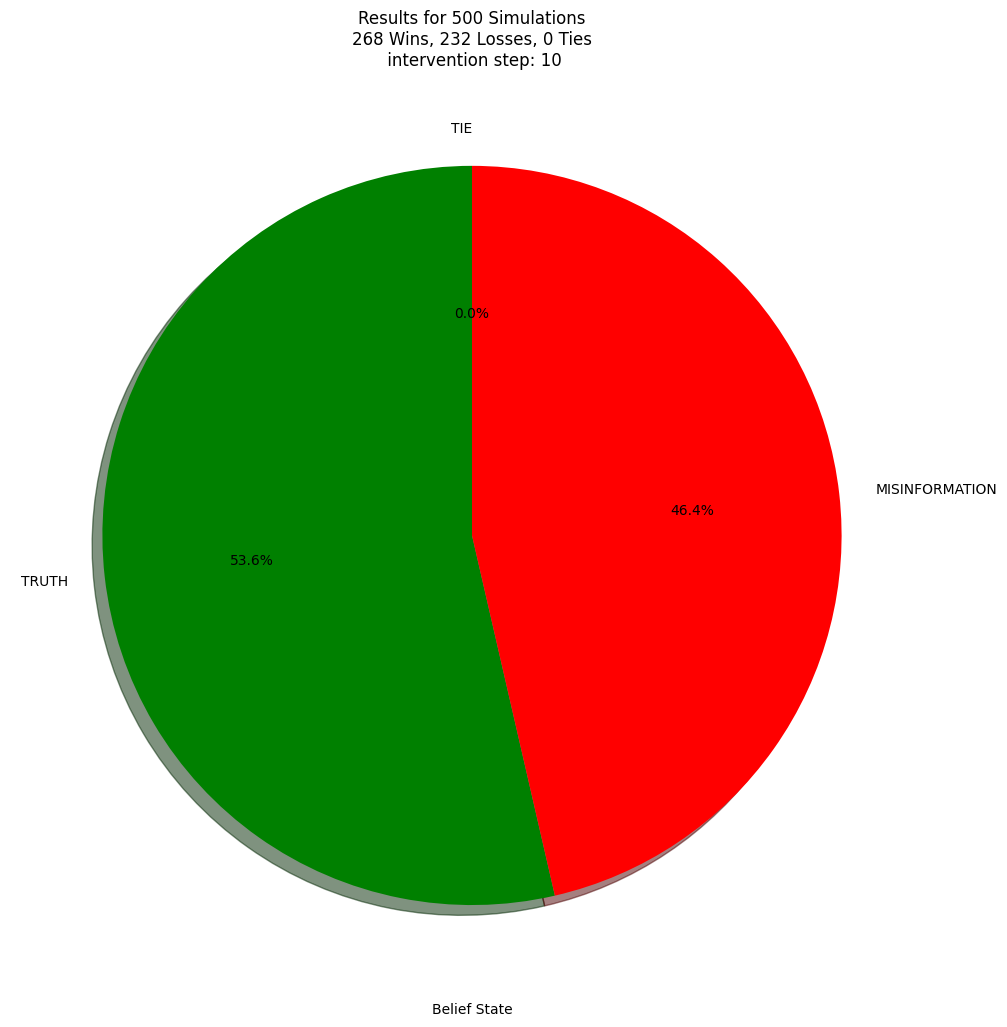

In [14]:
%matplotlib inline
# Define the types of information and virality of each information type
information_db = {
    'POLITICAL_MISINFO': {'type': 'misinformation', 'virality': 0.15},
    'SCIENTIFIC_MISINFO': {'type': 'misinformation', 'virality': 0.05},
    'POLITICAL_TRUTH': {'type': 'truth', 'virality': 0.10},
    'SCIENTIFIC_TRUTH': {'type': 'truth', 'virality': 0.04}
}

# Define node states
node_roles = {
    'NORMAL': {
        'convincing_power': 0.1,
        'shape': 'o',
        'base_size': 50,
    },
    'INFLUENCER': {
        'convincing_power': 0.5,
        'shape': 'o',
        'base_size': 75,
    },
    'GOOD_ACTOR': {
        'convincing_power': 0.025,
        'shape': '^',
        'base_size': 100,
    },
    'BAD_ACTOR': {
        'convincing_power': 0.025,
        'shape': 'v',
        'base_size': 100,
    }
}


# Define the colors for each node belief easier visualization.
color_map = {
    'SUSCEPTIBLE': 'gray',
    'SUSCEPTIBLE_INFLUENCER': 'yellow',
    'MISINFORMATION_INFLUENCER': 'lightred',
    'TRUTH_INFLUENCER': 'lightblue',
    'MISINFORMATION': 'red',
    'TRUTH': 'green',
}


def simulate_step(graph, roles_dict):
    # We collect nodes to update *after* looping
    # This prevents a node from being infected and spreading in the same step
    nodes_to_update = {} # Stores {node_to_infect: new_belief}

    for node in graph.nodes():
        current_belief = graph.nodes[node]['belief']

        # 1. Check if this node is a spreader
        # NOTE: add immune condition later.
        if current_belief == 'MISINFORMATION' or current_belief == 'TRUTH':

            # 2. Get the spreader's convincing power from their role
            role = graph.nodes[node]['role']
            power = roles_dict[role]['convincing_power']

            # 3. Find susceptible neighbors
            for neighbor in graph.neighbors(node):
                if graph.nodes[neighbor]['belief'] == 'SUSCEPTIBLE':

                    # 4. Roll the dice
                    if random.random() < power:

                        # We only update if they haven't been marked by another belief
                        if neighbor not in nodes_to_update:
                            nodes_to_update[neighbor] = current_belief

    # 5. Apply all updates at once
    for node, new_belief in nodes_to_update.items():
        # Only update if they are still susceptible (first-come, first-served)
        if graph.nodes[node]['belief'] == 'SUSCEPTIBLE':
            graph.nodes[node]['belief'] = new_belief

    return nodes_to_update

def setup_graph(N=200, M=3, popularity_condition=lambda x: x < 0.75):
    seed = random.randint(0, 100)
    G = nx.barabasi_albert_graph(n=N, m=M, seed=seed)

    # Set all node roles to 'NORMAL' and to the 'SUSCEPTIBLE' belief state
    for node in G.nodes():
        G.nodes[node]['role'] = 'NORMAL'
        G.nodes[node]['belief'] = 'SUSCEPTIBLE'

    # Find and set influencer nodes based on their degree
    all_degrees = [d for n, d in G.degree()]
    all_degrees.sort(reverse=True)
    highest_degree = all_degrees[0]

    for node in G.degree():
        if popularity_condition(node[1]):
            G.nodes[node[0]]['role'] = 'INFLUENCER'

    # Randomly assign some GOOD_ACTOR and BAD_ACTOR nodes
    GOOD_ACTORS_CAP = 2
    BAD_ACTORS_CAP = 2
    normal_nodes = [node for node in G.nodes() if G.nodes[node]['role'] == 'NORMAL']
    random.shuffle(normal_nodes)

    for i in range(GOOD_ACTORS_CAP):
        node_to_assign = normal_nodes.pop()
        G.nodes[node_to_assign]['role'] = 'GOOD_ACTOR'
        G.nodes[node_to_assign]['belief'] = 'TRUTH'

    for i in range(BAD_ACTORS_CAP):
        node_to_assign = normal_nodes.pop()
        G.nodes[node_to_assign]['role'] = 'BAD_ACTOR'
        G.nodes[node_to_assign]['belief'] = 'MISINFORMATION'

    # Set shapes based on node roles
    node_shapes = []
    for node in G.nodes():
        role = G.nodes[node]['role']
        node_shapes.append(node_roles[role]['shape'])

    # Set sizes of nodes based on their roles
    node_sizes = []
    for node in G.nodes():
        role = G.nodes[node]['role']

        size = node_roles[role]['base_size']

        if role == 'INFLUENCER':
            size = size + (G.degree[node] * 10)

        node_sizes.append(size)

    # Set colors based on node belief
    node_colors = []
    for node in G.nodes():
        belief = G.nodes[node]['belief']
        node_colors.append(color_map[belief])

    return G

def intervention(G, num_to_add):
    """
    Introduces an intervention by converting a number of susceptible nodes to truth spreaders.
    :param G:
    :param num_to_add:
    :return: Nodes Changed in {node_id: new_belief} | None
    """
    susceptible_nodes = [node for node in G.nodes() if G.nodes[node]['belief'] == 'SUSCEPTIBLE']
    if susceptible_nodes is None:
        print("No susceptible nodes found. Cannot introduce intervention.")
        return None
    # {node_id: new_belief} basically the same as nodes changed in simulate_step
    nodes_changed = {}
    random.shuffle(susceptible_nodes)


    for node in susceptible_nodes[:num_to_add]:
        G.nodes[node]['belief'] = 'TRUTH'
        nodes_changed[node] = 'TRUTH'

    return nodes_changed

intervention_step = 10
num_to_add = 5
fig, ax1 = plt.subplots(ncols=1, figsize=(12,12))

num_of_simulations = 500

print("STARTING SIMULATION...")

win_record = {'TRUTH': 0, 'MISINFORMATION': 0, 'TIE': 0}
truth_count = 0
misinformation_count = 0


for sim in range(num_of_simulations):
    G = setup_graph(200, 3, lambda x: x < 0.75)
    for frame in range(simulation_steps):
        if frame == intervention_step:
            intervention(G, 5)
        simulate_step(G, node_roles)
    for node in G.nodes():
        if G.nodes[node]['belief'] == 'TRUTH':
            truth_count += 1
        elif G.nodes[node]['belief'] == 'MISINFORMATION':
            misinformation_count += 1
    if truth_count > misinformation_count:
        win_record['TRUTH'] += 1
    elif truth_count < misinformation_count:
        win_record['MISINFORMATION'] += 1
    else:
        win_record['TIE'] += 1
    truth_count = 0
    misinformation_count = 0


print(win_record['TRUTH'])
print(win_record['MISINFORMATION'])
print(win_record['TIE'])

ax1.pie(win_record.values(), labels=win_record.keys(), autopct='%1.1f%%', shadow=True, startangle=90, colors=[color_map['TRUTH'], color_map['MISINFORMATION'], 'lightgray'])
ax1.set_title(f'Results for {num_of_simulations} Simulations\n{win_record["TRUTH"]} Wins, {win_record["MISINFORMATION"]} Losses, {win_record["TIE"]} Ties\n intervention step: {intervention_step}')

ax1.set_xlabel('Belief State')
plt.show()



## Discussion of Intervention Results

The introduction of an intervention step in the simulation produces mixed results. In some runs, the intervention successfully thwarts the spread of misinformation, leading to a significant increase in the number of nodes adopting the truth. However, in other runs, the intervention does little to prevent the spread of misinformation.
To further analyze the effectiveness of interventions, multiple simulations were run, and the outcomes were recorded.